In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# データ読み込み、外れ値の除外

# データセットの読み込み
df = sns.load_dataset('diamonds')

# 外れ値除外の前処理
df = df.drop(df[(df['x'] == 0) | (df['y'] == 0)| (df['z'] == 0)].index, axis=0)
df = df.drop(df[(df['x'] >= 10) | (df['y'] >= 10) | (df['z'] >= 10)].index, axis=0)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

(53911, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
# 特徴量と目的変数の設定
X = df.drop(['price'], axis=1)
y = df['price']

In [4]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (43128, 9)  y_trainの形状： (43128,)  X_testの形状： (10783, 9)  y_testの形状： (10783,)


In [5]:
# カテゴリ変数のlabel encoding
from sklearn.preprocessing import LabelEncoder

cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43128 entries, 2640 to 2732
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43128 non-null  float64
 1   cut      43128 non-null  int64  
 2   color    43128 non-null  int64  
 3   clarity  43128 non-null  int64  
 4   depth    43128 non-null  float64
 5   table    43128 non-null  float64
 6   x        43128 non-null  float64
 7   y        43128 non-null  float64
 8   z        43128 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 3.3 MB


In [6]:
# カテゴリ変数のデータ型をcategory型に変換
cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43128 entries, 2640 to 2732
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    43128 non-null  float64 
 1   cut      43128 non-null  category
 2   color    43128 non-null  category
 3   clarity  43128 non-null  category
 4   depth    43128 non-null  float64 
 5   table    43128 non-null  float64 
 6   x        43128 non-null  float64 
 7   y        43128 non-null  float64 
 8   z        43128 non-null  float64 
dtypes: category(3), float64(6)
memory usage: 2.4 MB


In [7]:
# 学習データの一部を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape, ' X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)

X_trの形状： (34502, 9)  y_trの形状： (34502,)  X_vaの形状： (8626, 9)  y_vaの形状： (8626,)


In [8]:
# ハイパーパラメータの設定
import lightgbm as lgb

lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

params = {
    'objective': 'mae',
    'seed': 0,
    'verbose': -1,
}

# 誤差プロットの格納用データ
evals_result = {}

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [9]:
# モデルの学習
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=10000,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['train', 'valid'],
                  callbacks=[lgb.early_stopping(100),
                             lgb.log_evaluation(500),
                             lgb.record_evaluation(evals_result)])

y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
score = mean_absolute_error(y_va, y_va_pred)
print(f'MAE valid: {score:.2f}')

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 228.505	valid's l1: 262.695
[1000]	train's l1: 206.936	valid's l1: 259.926
Early stopping, best iteration is:
[1290]	train's l1: 201.195	valid's l1: 259.42
MAE valid: 259.42


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

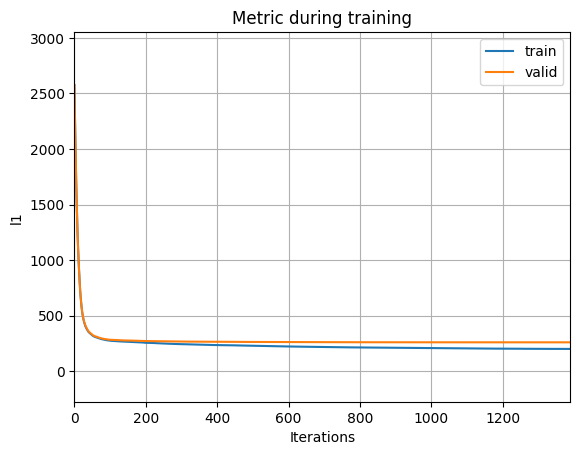

In [10]:
# 学習データと検証データの誤差プロット
lgb.plot_metric(evals_result)

In [11]:
# 学習が停止したブースティング回数
model.best_iteration

1290

In [12]:
# 検証データの予測と評価
y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
print('MAE valid: %.2f' % (mean_absolute_error(y_va, y_va_pred)))

MAE valid: 259.42


In [13]:
# テストデータの予測と評価
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('MAE test: %.2f' % (mean_absolute_error(y_test, y_test_pred)))

MAE test: 262.15


In [14]:
# テストデータの正解値と予測値の比較
print('正解値：', y_test[:5].values)
print('予測値：', y_test_pred[:5])
print('残差=正解値-予測値：', y_test[:5].values - y_test_pred[:5])

正解値： [3353 2930 4155 2780  684]
予測値： [3342.67131506 2976.16152667 4789.09481381 2879.06870253  745.54338877]
残差=正解値-予測値： [  10.32868494  -46.16152667 -634.09481381  -99.06870253  -61.54338877]


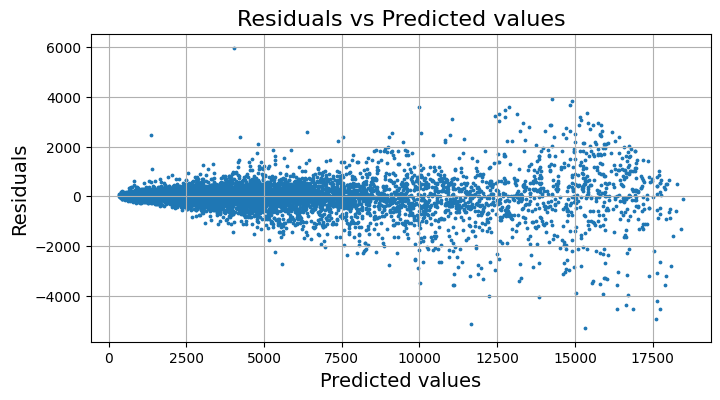

In [15]:
# 残差のプロット

# 残差の計算
residuals = y_test - y_test_pred
# 残差と予測値の散布図
plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.scatter(y_test_pred, residuals, s=3)
plt.xlabel('Predicted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residuals vs Predicted values', fontsize=16)
plt.grid()
plt.show()

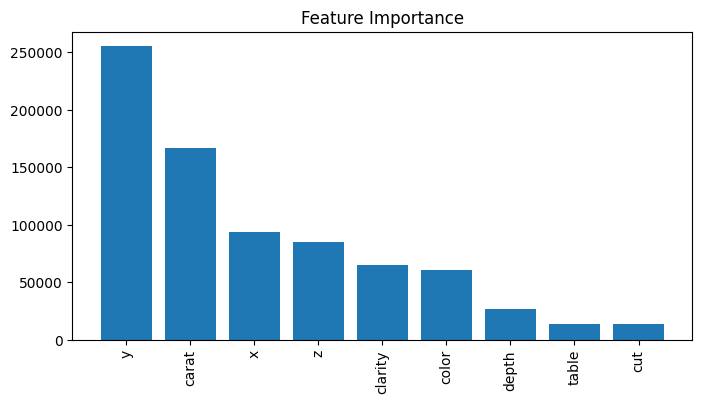

In [16]:
# 特徴量の重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量の重要度
indices = np.argsort(importances)[::-1] # 特徴量の重要度を降順にソート

plt.figure(figsize=(8, 4))
plt.title('Feature Importance')
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show()

In [17]:
# ライブラリshapのインストール
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.2 MB/s eta 0:00:00


In [18]:
# explainerの作成
import shap
explainer = shap.TreeExplainer(
    model = model,
    feature_perturbation = 'tree_path_dependent')

In [19]:
# SHAP値の計算
shap_values = explainer(X_test)

In [20]:
# 3件目の予測値
y_test_pred[2]

4789.09481380544

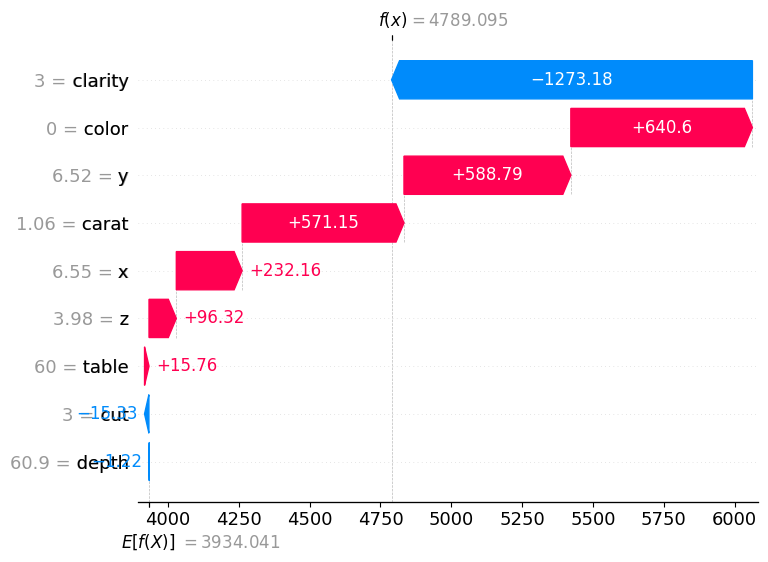

In [21]:
# 3件目のSHAP値の可視化
shap.plots.waterfall(shap_values[2])

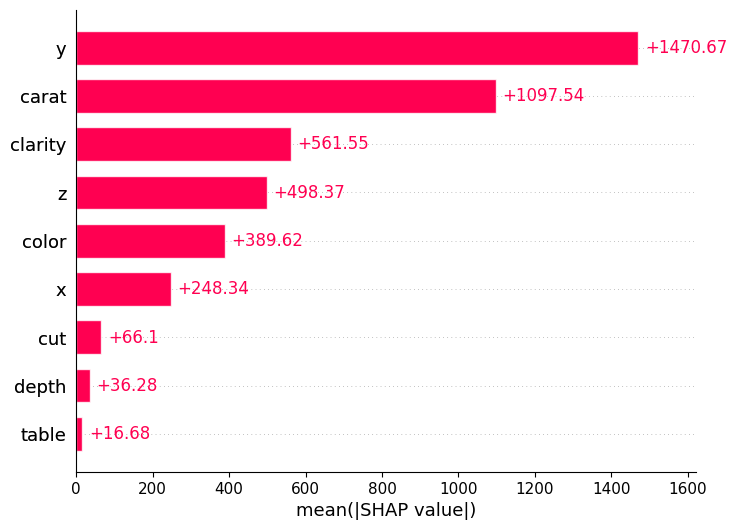

In [22]:
# 重要度の可視化
shap.plots.bar(shap_values)

In [23]:
# クロスバリデーション
from sklearn.model_selection import KFold

params = {
    'objective': 'mae',
    'seed': 0,
    'verbose': -1,
}

# 格納用データの作成
valid_scores = []
models = []
oof = np.zeros(len(X_train))

# KFoldを用いて学習データを5分割してモデルを作成
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for fold, (tr_idx, va_idx) in enumerate(kf.split(X_train)):
    X_tr = X_train.iloc[tr_idx]
    X_va = X_train.iloc[va_idx]
    y_tr = y_train.iloc[tr_idx]
    y_va = y_train.iloc[va_idx]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=10000,
                      valid_sets=[lgb_train, lgb_eval],
                      valid_names=['train', 'valid'],
                      callbacks=[lgb.early_stopping(100),
                                 lgb.log_evaluation(500)])

    y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
    score = mean_absolute_error(y_va, y_va_pred)
    print(f'fold {fold+1} MAE valid: {score:.2f}')
    print('')

    # スコア、モデル、予測値の格納
    valid_scores.append(score)
    models.append(model)
    oof[va_idx] = y_va_pred

# クロスバリデーションの平均スコア
cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score:.2f}')

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 228.505	valid's l1: 262.695
[1000]	train's l1: 206.936	valid's l1: 259.926
Early stopping, best iteration is:
[1290]	train's l1: 201.195	valid's l1: 259.42
fold 1 MAE valid: 259.42

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 225.3	valid's l1: 264.835
Early stopping, best iteration is:
[887]	train's l1: 211.514	valid's l1: 263.225
fold 2 MAE valid: 263.22

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 226.438	valid's l1: 268.231
[1000]	train's l1: 207.455	valid's l1: 266.401
Early stopping, best iteration is:
[1004]	train's l1: 207.415	valid's l1: 266.381
fold 3 MAE valid: 266.38

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 224.751	valid's l1: 270.8
Early stopping, best iteration is:
[874]	train's l1: 208.878	valid's l1: 268.227
fold 4 MAE valid: 268.23

Training until validation scores don't improve fo

In [24]:
# foldごとの検証データの誤差
valid_scores

[259.42017011346,
 263.22496238890284,
 266.3813346331067,
 268.2265597324658,
 266.2203312507181]

In [26]:
y_train

,price
2640,3230
18172,7371
17129,6838
18611,7597
44725,1619
...,...
45891,1721
52416,2514
42613,1332
43567,507


In [27]:
oof

array([3018.26389537, 7531.2939351 , 7909.73136023, ..., 1251.92873455,
        501.96591972, 3237.86495752])

In [28]:
oof.shape

(43128,)

In [25]:
# 検証データの誤差平均
print('MAE CV: %.2f' % (
      mean_absolute_error(y_train, oof)))

MAE CV: 264.69


In [29]:
# モデルごとのテストデータの予測
preds = []
for model in models:
  # クロスバリデーションで作成したモデルで予測
  y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)
  preds.append(y_test_pred)

y_test_preds = np.array(preds)
print('モデルごとの予測：', y_test_preds.shape)
print(y_test_preds)

モデルごとの予測： (5, 10783)
[[3342.67131506 2976.16152667 4789.09481381 ...  576.80837681
   463.8072284   642.1464844 ]
 [2976.61118347 3008.27889422 4738.16878541 ...  599.78080411
   464.69414431  632.94264372]
 [3093.76352825 3045.084876   4793.92145377 ...  624.46750355
   456.22876398  628.7647471 ]
 [3167.48968399 3040.53141546 4833.73061376 ...  613.63861591
   454.31252057  653.10834306]
 [2983.41274672 2963.69251003 4778.18069605 ...  610.82869837
   444.52732212  646.05719837]]


In [30]:
# 全モデルの予測平均
y_test_pred_mean = np.mean(y_test_preds ,axis=0)
print('全モデルの予測平均：', y_test_pred_mean.shape)
print(y_test_pred_mean)

全モデルの予測平均： (10783,)
[3112.7896915  3006.74984448 4786.61927256 ...  605.10479975  456.71399588
  640.60388333]


In [31]:
# 正解と予測平均の誤差
print('MAE test: %.2f' % (
      mean_absolute_error(y_test, y_test_pred_mean)))

MAE test: 254.58
